In [1]:
import sherpa
sherpa.__version__

'4.14.0'

In [2]:
import gammapy
gammapy.__version__

'0.20.1'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
from gammapy.datasets import SpectrumDataset
from gammapy.modeling.models import DatasetModels
from gammapy.maps import RegionGeom, RegionNDMap, MapAxis
from sherpa.astro.instrument import RSPModelPHA

class SherpaSpectrumDataset(SpectrumDataset):
    """
    Parameters
    ----------
    data: `sherpa.data.Data` or `sherpa.data.DataSimulFit`
        An instance of a sherpa.data data-derived class
    stat: str or sherpa.stats.Stat instance
        A fit statistic from sherpa.stats
    """
    
    tag = "SherpaSpectrumDataset"

    # TODO: implement a model wrapper to fit any kind of Gammapy model (for now only sherpa models work)
    # TODO: implement read methods
    # TODO: handle the REGION and GTI information somewhere
    # TODO: possibly add counts, bkg and IRFs as properties
    # TODO: handle mask safe and mask fit somehow
    # TODO: implement compute residuals
    
    def __init__(self, data, stat, **kwargs):
        self.data = data
        if isinstance(stat, str) and not stat in ui.list_stats():
            raise ValueError("Invalid stat")
        self._stat = stat
        super().__init__(**kwargs)
            
    @property
    def _ebins(self):
        lo, hi = self.data._get_ebins()
        mask = self.data.mask
        lo = lo[mask].squeeze()
        hi = hi[mask].squeeze()
        return lo, hi
            
    @property
    def _energy_axis_reco(self):
        """Grouped reconstructed energy axis."""
        lo, hi = self._ebins
        energy_edges = np.append(lo, hi[-1])
        energy_edges = energy_edges
        # TODO: is the unit always keV and the interp always "lin"?
        return MapAxis.from_energy_edges(energy_edges, unit=u.keV, name="energy", interp='lin')

    @property
    def _geom(self):
        # TODO: read the region or pass it in init
        return RegionGeom(region=None, axes=[self._energy_axis_reco])
        
    @property
    def counts(self):
        # TODO: read the units somehow. Hardcoded for now
        data = self.data.get_y(filter=True)
        return RegionNDMap.from_geom(
            self._geom, 
            data=data, 
            unit='keV-1 s-1', 
        )
    
    @counts.setter
    def counts(self, counts):
        pass
    
    @property
    def background(self):
        # TODO: read the units somehow. Hardcoded for now
        data = self.data.get_background().get_y(filter=True)
        return RegionNDMap.from_geom(
            self._geom, 
            data=data, 
            unit='keV-1 s-1', 
        )

    @background.setter
    def background(self, background):
        pass

    def npred_signal(self):
        from sherpa.astro.ui import get_model_plot
        data = self.data.eval_model_to_fit(self._sherpa_model)
        data /= self.data.exposure
        # TODO: read the units somehow. Hardcoded for now
        return RegionNDMap.from_geom(
            self._geom, 
            data=data, 
            unit='keV-1 s-1', 
        )

    @property
    def _sherpa_model(self):
        """Sherpa model convolved with the IRFs"""
        arf = self.data.get_arf()
        rmf = self.data.get_rmf()
        model = self.models[0]
        return RSPModelPHA(arf, rmf, data, model)
        
    @property
    def models(self):
        return self._models
        
    @models.setter
    def models(self, models):
        """Models setter. For now only sherpa-derived models (`sherpa.models.model.Model` or 
        `sherpa.models.model.SimulFitModel`) are supported"""
        if models is not None:
            models = DatasetModels(models)
            models = models.select(datasets_names=self.name)
            for model in models:
                model._exposure = self.data.exposure
        self._models = models   
               
    def notice(self, lo, hi, ignore=False):
        # TODO: implement mask safe and mask fit accordingly
        self.data.notice(lo, hi, ignore)
        
    @property
    def stat(self):
        """Fit statistic"""
        return self._stat
    
    @stat.setter
    def stat(self, stat):
        """Fit statistic setter"""
        self._stat = stat

    @property
    def stat_type(self):
        """Fit statistic name"""
        return self._stat.name

    def _calc_stat(self):
        stat_sum, stat_array = self.stat.calc_stat(self.data, self._sherpa_model)
        return stat_sum, stat_array
    
    def stat_sum(self):
        """Total statistic given the current model parameters."""
        return float(self._calc_stat()[0])

    def stat_array(self):
        """Likelihood per bin given the current model parameters"""
        return self._calc_stat()[0].astype(float)

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [3]:
from sherpa.astro.ui import unpack_pha
data = unpack_pha("XMM_test_files/MOS1_PWN.grp")

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'
read ARF file XMM_test_files/MOS1_PWN.arf


/home/lucagiunti/miniconda3/envs/gammapyXrayNEW/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'XMM_test_files/MOS1_PWN.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/home/lucagiunti/miniconda3/envs/gammapyXrayNEW/lib/python3.9/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'XMM_test_files/MOS1_PWN.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


read RMF file XMM_test_files/MOS1_PWN.rmf
read background file XMM_test_files/MOS1_PWN_bkg.fits


In [7]:
data.subtract()

In [8]:
#from sherpa.stats import WStat
#stat = WStat()

In [9]:
from sherpa.stats import Chi2Gehrels
stat = Chi2Gehrels()

In [10]:
dataset = SherpaSpectrumDataset(data, stat)

<AxesSubplot: xlabel='Energy [keV]', ylabel='$\\mathrm{keV^{-1}\\,s^{-1}}$'>

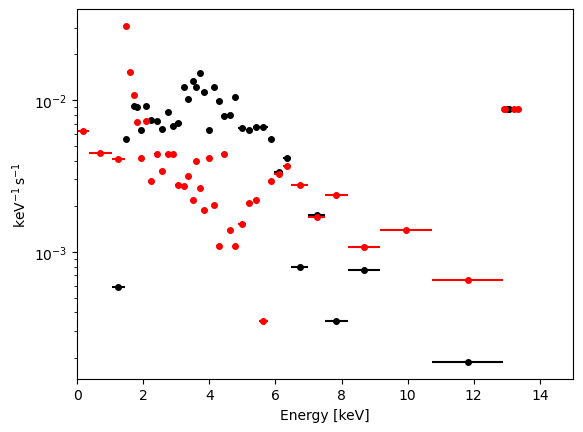

In [11]:
dataset.counts.plot(color="k")
dataset.background.plot(color="r")

In [12]:
dataset.notice(2, 8, ignore=False)

<AxesSubplot: xlabel='Energy [keV]', ylabel='$\\mathrm{keV^{-1}\\,s^{-1}}$'>

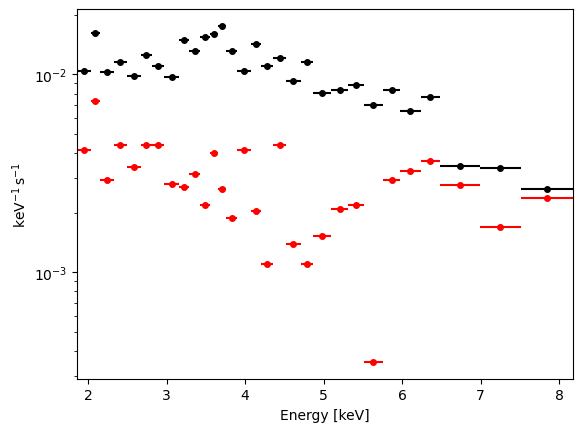

In [10]:
dataset.counts.plot(color="k")
dataset.background.plot(color="r")

In [13]:
import astropy.units as u
import numpy as np
from gammapy.modeling.models import SpectralModel
from gammapy.modeling import Parameter, Parameters
from sherpa.models import BinaryOpModel

class SherpaSpectralModel(SpectralModel):
    """A wrapper for Sherpa spectral models.
    Parameters
    ----------
    sherpa_model :
        An instance of the models defined in `~sherpa.models` or `~sherpa.astro.xspec`.
    default_units : tuple
        Units of the input energy array and output model evaluation (find them in the sherpa/xspec docs!)
    """

    tag = ["SherpaSpectralModel", "sherpa", "xspec"]

    def __init__(
        self, sherpa_model, name=None
    ):
        self.datasets_names = None
        self._exposure = None
        self._sherpa_model = sherpa_model
        self._name = name
        self.default_parameters = self._wrap_parameters()
        super().__init__()
    
    @property
    def ndim(self):
        return self.sherpa_model.ndim
    
    @property
    def pars(self):
        return self.sherpa_model.pars

    @property
    def is_discrete(self):
        return self.sherpa_model.is_discrete

    @property
    def name(self):
        if self._name:
            return self._name
        else:
            return self.sherpa_model.name

    @property
    def sherpa_model(self):
        if self._exposure:
            return self._exposure * self._sherpa_model
        else:
            return self._sherpa_model
        
    def _wrap_parameters(self):
        "Wraps sherpa model parameters into a gammapy Parameters object"
        parameters = []
        for par in self.sherpa_model.pars:
            is_norm = par.name in ["ampl", "norm", "K"]
            parameter = Parameter(
                name=par.name, 
                value=par.val, 
                frozen=par.frozen, 
                min=par.min,
                max=par.max,
                is_norm=is_norm,
                interp="log"
            )
            parameters.append(parameter)
        return Parameters(parameters)
       
    def _update_sherpa_parameters(self):
        """Update sherpa model parameters"""
        for idx, par in enumerate(self.parameters):
            self.sherpa_model.pars[idx].val = par.value
            
    def calc(self, pars, x, xhi=None, *args, **kwargs):
        self._update_sherpa_parameters()
        #print(self.sherpa_model.pars[2].val)
        #print(self.sherpa_model.pars[0].val)
        return self.sherpa_model.calc(pars, x, xhi, *args, **kwargs)
    
    #def __call__(self, *args, **kwargs):
    #    self._update_sherpa_parameters()
    #    return self.sherpa_model.__call__(*args, **kwargs)

In [14]:
from sherpa.models.basic import PowLaw1D
from sherpa.astro.xspec import XSTBabs
pl = PowLaw1D()
pl.gamma.val = 1.5
pl.gamma.min = 1
pl.gamma.max = 4
pl.gamma.frozen = True
pl.ampl.val = 3e-4
pl.ampl.min = 1e-7
pl.ampl.max = 1e-1
absorption = XSTBabs()
absorption.nH = 5
absorption.nH.frozen = True
model = pl*absorption

In [15]:
wrapped_model = SherpaSpectralModel(model)

In [126]:
model

<BinaryOpModel model instance '(powlaw1d * tbabs)'>

In [36]:
wrapped_model.sherpa_model

<BinaryOpModel model instance '(powlaw1d * tbabs)'>

In [16]:
dataset.models = [wrapped_model]

In [159]:
dataset._sherpa_model

<RSPModelPHA model instance 'apply_rmf(apply_arf((11370.57 * (powlaw1d * tbabs))))'>

<AxesSubplot: xlabel='Energy [keV]', ylabel='$\\mathrm{keV^{-1}\\,s^{-1}}$'>

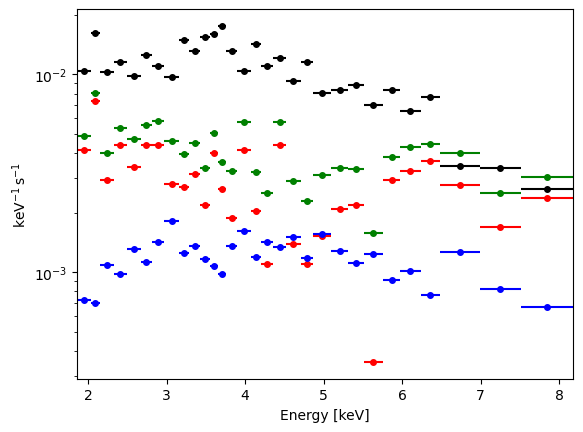

In [81]:
dataset.counts.plot(color="k")
dataset.background.plot(color="r")
dataset.npred_signal().plot(color="b")
(dataset.background+dataset.npred_signal()).plot(color="g")

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


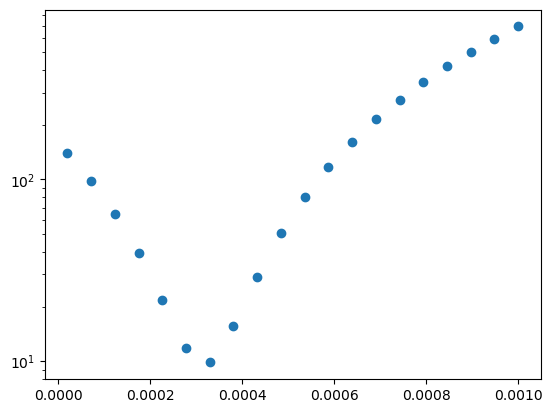

In [17]:
ampls = np.linspace(0.2, 10, 20)*1e-4
stats=[]
for ampl in ampls:
    pl.ampl.val = ampl
    stats.append(dataset.stat_sum())
plt.scatter(ampls, stats)
plt.yscale("log")

In [18]:
dataset.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str5,float64,str1,int64,float64,float64,bool,bool,str1
spectral,gamma,1.5000e+00,,0.000e+00,1.000e+00,4.000e+00,True,False,
spectral,ref,1.0000e+00,,0.000e+00,-3.403e+38,3.403e+38,True,False,
spectral,ampl,3.0000e-04,,0.000e+00,1.000e-07,1.000e-01,False,True,
spectral,nH,5.0000e+00,,0.000e+00,0.000e+00,1.000e+06,True,False,


In [19]:
from gammapy.modeling import Fit

fit = Fit(store_trace=True, )
minuit_opts = {"tol": 0.001,}
fit.backend = "minuit"
#fit.optimize_opts = minuit_opts
result = fit.run([dataset])

In [20]:
result

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 107
	total stat : 10.04

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [21]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str5,float64,str1,float64,float64,float64,bool,bool,str1
spectral,gamma,1.5000e+00,,0.000e+00,1.000e+00,4.000e+00,True,False,
spectral,ref,1.0000e+00,,0.000e+00,-3.403e+38,3.403e+38,True,False,
spectral,ampl,3.0000e-04,,7.733e-03,1.000e-07,1.000e-01,False,True,
spectral,nH,5.0000e+00,,0.000e+00,0.000e+00,1.000e+06,True,False,


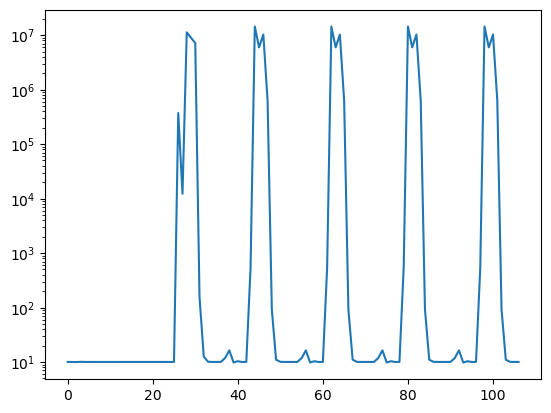

In [22]:
plt.plot(result.trace["total_stat"])
plt.yscale("log")

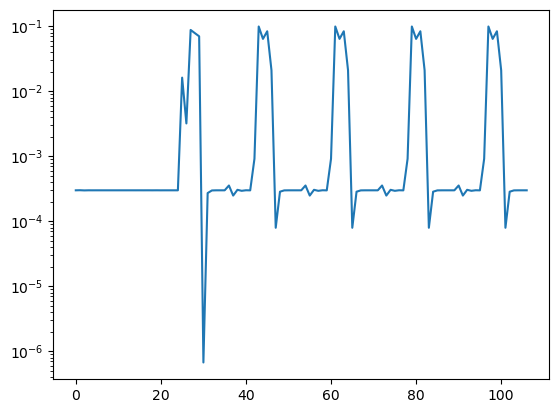

In [23]:
plt.plot(result.trace["(11370.57 * (powlaw1d * tbabs)).spectral.ampl"])
plt.yscale("log")

<AxesSubplot: xlabel='Energy [keV]', ylabel='$\\mathrm{keV^{-1}\\,s^{-1}}$'>

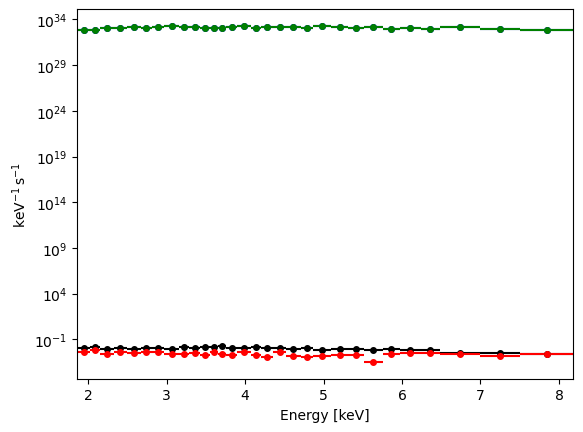

In [134]:
dataset.counts.plot(color="k")
dataset.background.plot(color="r")
dataset.npred_signal().plot(color="b")
(dataset.background+dataset.npred_signal()).plot(color="g")